In [1]:
from paths import *
from utils import *

from io import StringIO

import re
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from statsmodels.stats.proportion import proportion_confint
%matplotlib inline
sns.set_context('notebook', font_scale=1.4)
sns.set_style("whitegrid")

plt.rcParams['figure.dpi'] = 300
ALPHA = 0.05

# Diagnosis

## Tables

### GPT3

In [2]:
# Read original vignettes
vignettes = parse_vignettes_2015(RAW/'vignettes-2015.txt') # the order is same as the original paper
vignettes.head()

,Correct Diagnosis,Problem,Simplified,Correct Triage
0,Acute liver failure,A 48-year-old woman with a history of migraine...,"48 y/o f, confusion, disorientation, increasin...",Emergent
1,Appendicitis,A 12-year-old girl presents with sudden-onset ...,"12 y/o f, sudden onset severe abdominal pain, ...",Emergent
2,Asthma,A 27-year-old woman with a history of moderate...,"27 y/o f, Hx of asthma, mild shortness of brea...",Emergent
3,COPD flare (more severe),A 67-year-old woman with a history of COPD pre...,"67 y/o f, Hx of COPD, 3 days worsening shortne...",Emergent
4,Deep vein thrombosis,A 65-year-old woman presents with unilateral l...,"65 y/o f, 5 days swelling, pain in one leg, re...",Emergent


In [3]:
# Get GPT3 graded vignettes
gpt3_dx_graded = pd.read_excel(PROCESSED/'vignettes_diagnosis_predictions_instruct_graded.xlsx', 
                               sheet_name=0,  index_col=[0, 1, 2, 3, 4, 5]).reset_index()
gpt3_dx_graded['Top-1'] = gpt3_dx_graded['Top Dx Correct?'] == 'Yes'
gpt3_dx_graded['Top-3'] = gpt3_dx_graded['Correct Dx in Top-3?'] == 'Yes'
gpt3_dx_graded["Vignette"] = gpt3_dx_graded["Vignette"].map(
    lambda s: s+'.' if not s.endswith('.') else s)
gpt3_dx_graded["Vignette"]  = gpt3_dx_graded["Vignette"].map(
    lambda s: s.replace("Â", "").replace("â€™", "’").replace("â€“", '–'))

# Add triage info
adp2triage = vignettes.set_index(['Problem'])['Correct Triage'].to_dict()
gpt3_dx_graded['Correct Triage'] = gpt3_dx_graded.apply(
    lambda row: adp2triage[row["Vignette"]], axis=1)
print(gpt3_dx_graded.shape)

gpt3_dx_graded.rename({"Vignette": "Problem"}, axis=1, inplace=True)
gpt3_dx_graded.head()

(102, 10)


,Problem,Correct Diagnosis,Top Predicted Dx,Top Dx Correct?,Top-3 Predicted Dx,Correct Dx in Top-3?,Number of predictions,Top-1,Top-3,Correct Triage
0,"A 12-year-old female presents with dry, itchy ...",Eczema,Atopic dermatitis,Yes,Atopic dermatitis,Yes,44,True,True,Self-care
1,A 12-year-old girl presents with sudden-onset ...,Appendicitis,Appendicitis,Yes,Appendicitis,Yes,41,True,True,Emergent
2,A 12-year-old girl presents with sudden-onset ...,Appendicitis,Appendicitis,Yes,Acute appendicitis,Yes,3,True,True,Emergent
3,"A 14-year-old boy presents with nausea, vomiti...",Salmonella,Campylobacter enteritis,No,Campylobacter enteritis,No,23,False,False,Non-emergent
4,"A 14-year-old boy presents with nausea, vomiti...",Salmonella,Campylobacter enteritis,No,Food poisoning,No,12,False,False,Non-emergent


In [4]:
# Get per vignette performance (Not possible without per prediction annotation)
# # Get number of total and correct predictions
# gpt3_dx_graded["Number of correct predictions"] =\
#     (gpt3_dx_graded["Predicted Dx Correct?"] == "Yes") * (gpt3_dx_graded["Number of predictions"])
# per_vignette_dx_gpt3 = (gpt3_dx_graded
#  .groupby(["Problem", "Additional Details", "Correct Diagnosis"])
#  [["Number of predictions", "Number of correct predictions"]]
#  .agg(sum))

# # Find probability of correct prediction
# per_vignette_dx_gpt3["Pr(correct prediction)"] =\
#     per_vignette_dx_gpt3["Number of correct predictions"] / per_vignette_dx_gpt3["Number of predictions"]
# per_vignette_dx_gpt3.reset_index(inplace=True)

# # Set index to match original file
# adp2idx = vignettes20.reset_index().set_index(["Additional Details", "Problem"])["index"]
# per_vignette_dx_gpt3.index = per_vignette_dx_gpt3.apply(
#     lambda row: adp2idx[(row["Additional Details"], row["Problem"])], axis=1)
# per_vignette_dx_gpt3.sort_index(inplace=True)

# # Add triage info
# per_vignette_dx_gpt3['Correct Triage'] = per_vignette_dx_gpt3.apply(
#     lambda row: adp2triage[(row["Additional Details"], row["Problem"])], axis=1)
# print(per_vignette_dx_gpt3.shape)
# per_vignette_dx_gpt3.head()

In [5]:
# Calculate aggregated performance
gpt3_dx_perf = gpt3_dx_graded.drop_duplicates(
    ["Problem", "Correct Diagnosis"], keep="first")
gpt3_dx_perf = gpt3_dx_perf.groupby('Correct Triage')\
    [['Top-1', 'Top-3']].\
    agg([len, sum])
gpt3_dx_perf.loc['All'] = gpt3_dx_perf.sum()
gpt3_dx_perf.rename(columns={'sum': '# Correct', 'len': 'N'}, inplace=True)

# Get confidence intervals
data = []
for i, row in gpt3_dx_perf.iterrows():
    for col in ['Top-1', 'Top-3']:
        n, total = row[col].values
        row.loc[(col, 'LB')], row.loc[(col, 'UB')] =\
            proportion_confint(count=total, nobs=n, alpha=ALPHA, method='wilson')
        row.loc[(col, 'LB')]*= 100; row.loc[(col, 'UB')] *= 100
        row.loc[(col, 'Mean')] = (total/n)*100
    row.name = i
    data.append(row)
    
gpt3_dx_perf = pd.DataFrame(data)
gpt3_dx_perf.sort_index(axis=1, inplace=True)
gpt3_dx_perf

Top-1                                            Top-3  \
             # Correct         LB       Mean     N         UB # Correct   
Emergent          13.0  62.118017  86.666667  15.0  96.263874      15.0   
Non-emergent      11.0  48.049566  73.333333  15.0  89.102547      13.0   
Self-care         10.0  41.713548  66.666667  15.0  84.823676      15.0   
All               34.0  61.326620  75.555556  45.0  85.764521      43.0   

                                                       
                     LB        Mean     N          UB  
Emergent      79.611670  100.000000  15.0  100.000000  
Non-emergent  62.118017   86.666667  15.0   96.263874  
Self-care     79.611670  100.000000  15.0  100.000000  
All           85.172489   95.555556  45.0   98.772587

### Symptom Checker

In [6]:
# Get symptom checker tables
sym_agg = pd.read_html('<div class="table"><div class="table-caption"><div class="highwire-markup-wrapper highwire-get-markup"><div class="highwire-markup"><div xmlns="http://www.w3.org/1999/xhtml" id="content-block" xmlns:xhtml="http://www.w3.org/1999/xhtml"><div class="table-expansion " id="T4"><span class="highwire-journal-article-marker-start"></span><div class="table-caption"><span class="table-label">Table 4</span> <p id="p-39"> Accuracy of diagnosis decision and triage advice for each symptom checker</p><div class="sb-div caption-clear"></div></div><table id="table-4"><thead id="thead-4"><tr id="tr-54"><th colspan="1" rowspan="3" align="left" valign="top" id="th-44" class="table-left table-vtop">Symptom checker (n=23)</th><th colspan="6" rowspan="1" align="center" valign="top" id="th-45" class="table-center table-vtop">Diagnosis</th><th colspan="1" rowspan="3" align="center" valign="top" id="th-46" class="table-center table-vtop"></th><th colspan="8" rowspan="1" align="center" valign="top" id="th-47" class="table-center table-vtop">Triage</th></tr><tr id="tr-55"><th colspan="2" rowspan="1" align="center" valign="top" id="th-48" class="table-center table-vtop">Listed first</th><th colspan="2" rowspan="1" align="center" valign="top" id="th-49" class="table-center table-vtop">Listed in top 3</th><th colspan="2" rowspan="1" align="center" valign="top" id="th-50" class="table-center table-vtop">Listed in top 20</th><th colspan="2" rowspan="1" align="center" valign="top" id="th-51" class="table-center table-vtop">All cases</th><th colspan="2" rowspan="1" align="center" valign="top" id="th-52" class="table-center table-vtop">Emergent care required</th><th colspan="2" rowspan="1" align="center" valign="top" id="th-53" class="table-center table-vtop">Non-emergent care reasonable</th><th colspan="2" rowspan="1" align="center" valign="top" id="th-54" class="table-center table-vtop">Self care reasonable</th></tr><tr id="tr-56"><th colspan="1" rowspan="1" align="center" valign="top" id="th-55" class="table-center table-vtop">Rate*</th><th colspan="1" rowspan="1" align="center" valign="top" id="th-56" class="table-center table-vtop">% (95% CI)</th><th colspan="1" rowspan="1" align="center" valign="top" id="th-57" class="table-center table-vtop">Rate*</th><th colspan="1" rowspan="1" align="center" valign="top" id="th-58" class="table-center table-vtop">% (95% CI)</th><th colspan="1" rowspan="1" align="center" valign="top" id="th-59" class="table-center table-vtop">Rate*</th><th colspan="1" rowspan="1" align="center" valign="top" id="th-60" class="table-center table-vtop">% (95% CI)</th><th colspan="1" rowspan="1" align="center" valign="top" id="th-61" class="table-center table-vtop">Rate*</th><th colspan="1" rowspan="1" align="center" valign="top" id="th-62" class="table-center table-vtop">% (95% CI)</th><th colspan="1" rowspan="1" align="center" valign="top" id="th-63" class="table-center table-vtop">Rate*</th><th colspan="1" rowspan="1" align="center" valign="top" id="th-64" class="table-center table-vtop">% (95% CI)</th><th colspan="1" rowspan="1" align="center" valign="top" id="th-65" class="table-center table-vtop">Rate*</th><th colspan="1" rowspan="1" align="center" valign="top" id="th-66" class="table-center table-vtop">% (95% CI)</th><th colspan="1" rowspan="1" align="center" valign="top" id="th-67" class="table-center table-vtop">Rate*</th><th colspan="1" rowspan="1" align="center" valign="top" id="th-68" class="table-center table-vtop">% (95% CI)</th></tr></thead><tbody id="tbody-4"><tr id="tr-57"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-405" class="table-left table-vmiddle">Ask MD</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-406" class="table-center table-vmiddle">17/40</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-407" class="table-center table-vmiddle">43 (26 to 59)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-408" class="table-center table-vmiddle">27/40</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-409" class="table-center table-vmiddle">68 (52 to 83)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-410" class="table-center table-vmiddle">30/40</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-411" class="table-center table-vmiddle">75 (61 to 89)</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-412" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-413" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-414" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-415" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-416" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-417" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-418" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-419" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-420" class="table-center table-vmiddle">—†</td></tr><tr id="tr-58"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-421" class="table-left table-vmiddle">BetterMedicine</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-422" class="table-center table-vmiddle">11/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-423" class="table-center table-vmiddle">24 (11 to 38)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-424" class="table-center table-vmiddle">13/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-425" class="table-center table-vmiddle">29 (15 to 43)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-426" class="table-center table-vmiddle">17/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-427" class="table-center table-vmiddle">38 (23 to 53)</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-428" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-429" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-430" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-431" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-432" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-433" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-434" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-435" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-436" class="table-center table-vmiddle">—†</td></tr><tr id="tr-59"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-437" class="table-left table-vmiddle">DocResponse</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-438" class="table-center table-vmiddle">18/36</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-439" class="table-center table-vmiddle">50 (33 to 67)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-440" class="table-center table-vmiddle">24/36</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-441" class="table-center table-vmiddle">67 (50 to 83)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-442" class="table-center table-vmiddle">26/36</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-443" class="table-center table-vmiddle">72 (57 to 88)</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-444" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-445" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-446" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-447" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-448" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-449" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-450" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-451" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-452" class="table-center table-vmiddle">—†</td></tr><tr id="tr-60"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-453" class="table-left table-vmiddle">Doctor Diagnose</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-454" class="table-center table-vmiddle">16/39</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-455" class="table-center table-vmiddle">41 (25 to 57)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-456" class="table-center table-vmiddle">17/39</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-457" class="table-center table-vmiddle">44 (27 to 60)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-458" class="table-center table-vmiddle">18/39</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-459" class="table-center table-vmiddle">46 (30 to 63)</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-460" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-461" class="table-center table-vmiddle">10/16</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-462" class="table-center table-vmiddle">63 (36 to 89)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-463" class="table-center table-vmiddle">8/10</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-464" class="table-center table-vmiddle">80 (13 to 100)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-465" class="table-center table-vmiddle">2/3</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-466" class="table-center table-vmiddle">67 (0 to 100)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-467" class="table-center table-vmiddle">0/3</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-468" class="table-center table-vmiddle">0 (0 to0)</td></tr><tr id="tr-61"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-469" class="table-left table-vmiddle">Drugs.com</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-470" class="table-center table-vmiddle">17/43</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-471" class="table-center table-vmiddle">40 (24 to 55)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-472" class="table-center table-vmiddle">20/43</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-473" class="table-center table-vmiddle">47 (31 to 63)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-474" class="table-center table-vmiddle">25/43</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-475" class="table-center table-vmiddle">58 (43 to74)</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-476" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-477" class="table-center table-vmiddle">25/42</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-478" class="table-center table-vmiddle">60 (44 to75)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-479" class="table-center table-vmiddle">8/14</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-480" class="table-center table-vmiddle">57 (27 to 87)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-481" class="table-center table-vmiddle">9/15</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-482" class="table-center table-vmiddle">60 (32 to 88)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-483" class="table-center table-vmiddle">8/13</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-484" class="table-center table-vmiddle">62 (31 to 92)</td></tr><tr id="tr-62"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-485" class="table-left table-vmiddle">EarlyDoc</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-486" class="table-center table-vmiddle">6/19</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-487" class="table-center table-vmiddle">32 (9 to 55)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-488" class="table-center table-vmiddle">7/19</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-489" class="table-center table-vmiddle">33 (9 to 57)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-490" class="table-center table-vmiddle">7/19</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-491" class="table-center table-vmiddle">33 (9 to57)</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-492" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-493" class="table-center table-vmiddle">9/17</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-494" class="table-center table-vmiddle">53 (26 to79)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-495" class="table-center table-vmiddle">4/6</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-496" class="table-center table-vmiddle">67 (12 to 100)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-497" class="table-center table-vmiddle">3/5</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-498" class="table-center table-vmiddle">60 (0 to 100)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-499" class="table-center table-vmiddle">2/6</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-500" class="table-center table-vmiddle">33 (0 to 88)</td></tr><tr id="tr-63"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-501" class="table-left table-vmiddle">Esagil</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-502" class="table-center table-vmiddle">9/44</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-503" class="table-center table-vmiddle">20 (8 to33)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-504" class="table-center table-vmiddle">15/44</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-505" class="table-center table-vmiddle">34 (24 to 54)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-506" class="table-center table-vmiddle">22/44</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-507" class="table-center table-vmiddle">50 (35 to65)</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-508" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-509" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-510" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-511" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-512" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-513" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-514" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-515" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-516" class="table-center table-vmiddle">—†</td></tr><tr id="tr-64"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-517" class="table-left table-vmiddle">Family Doctor</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-518" class="table-center table-vmiddle">20/43</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-519" class="table-center table-vmiddle">47 (31 to62)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-520" class="table-center table-vmiddle">24/43</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-521" class="table-center table-vmiddle">56 (40 to 71)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-522" class="table-center table-vmiddle">24/43</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-523" class="table-center table-vmiddle">56 (40 to71)</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-524" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-525" class="table-center table-vmiddle">22/41</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-526" class="table-center table-vmiddle">54 (38 to70)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-527" class="table-center table-vmiddle">6/12</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-528" class="table-center table-vmiddle">50 (17 to 83)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-529" class="table-center table-vmiddle">7/14</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-530" class="table-center table-vmiddle">50 (20 to 80)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-531" class="table-center table-vmiddle">9/15</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-532" class="table-center table-vmiddle">60 (32 to 88)</td></tr><tr id="tr-65"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-533" class="table-left table-vmiddle">FreeMD</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-534" class="table-center table-vmiddle">16/44</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-535" class="table-center table-vmiddle">36 (22 to51)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-536" class="table-center table-vmiddle">20/44</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-537" class="table-center table-vmiddle">45 (30 to 61)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-538" class="table-center table-vmiddle">21/44</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-539" class="table-center table-vmiddle">48 (32 to63)</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-540" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-541" class="table-center table-vmiddle">26/44</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-542" class="table-center table-vmiddle">59 (44 to74)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-543" class="table-center table-vmiddle">10/15</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-544" class="table-center table-vmiddle">67 (40 to 94)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-545" class="table-center table-vmiddle">13/15</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-546" class="table-center table-vmiddle">87 (67 to 100)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-547" class="table-center table-vmiddle">3/14</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-548" class="table-center table-vmiddle">21 (0 to 46)</td></tr><tr id="tr-66"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-549" class="table-left table-vmiddle">HMS Family Health Guide</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-550" class="table-center table-vmiddle">13/38</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-551" class="table-center table-vmiddle">34 (18 to50)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-552" class="table-center table-vmiddle">20/38</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-553" class="table-center table-vmiddle">52 (39 to 72)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-554" class="table-center table-vmiddle">21/38</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-555" class="table-center table-vmiddle">55 (39 to72)</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-556" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-557" class="table-center table-vmiddle">32/40</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-558" class="table-center table-vmiddle">78 (64 to91)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-559" class="table-center table-vmiddle">13/14</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-560" class="table-center table-vmiddle">93 (77 to 100)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-561" class="table-center table-vmiddle">11/13</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-562" class="table-center table-vmiddle">85 (62 to 100)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-563" class="table-center table-vmiddle">8/13</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-564" class="table-center table-vmiddle">62 (31 to 92)</td></tr><tr id="tr-67"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-565" class="table-left table-vmiddle">Healthline</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-566" class="table-center table-vmiddle">17/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-567" class="table-center table-vmiddle">38 (23 to53)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-568" class="table-center table-vmiddle">24/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-569" class="table-center table-vmiddle">53 (37 to 68)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-570" class="table-center table-vmiddle">26/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-571" class="table-center table-vmiddle">58 (43 to73)</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-572" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-573" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-574" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-575" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-576" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-577" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-578" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-579" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-580" class="table-center table-vmiddle">—†</td></tr><tr id="tr-68"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-581" class="table-left table-vmiddle">Healthwise</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-582" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-583" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-584" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-585" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-586" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-587" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-588" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-589" class="table-center table-vmiddle">19/44</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-590" class="table-center table-vmiddle">43 (28 to58)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-591" class="table-center table-vmiddle">15/15</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-592" class="table-center table-vmiddle">100 (100 to 100)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-593" class="table-center table-vmiddle">1/15</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-594" class="table-center table-vmiddle">7 (0 to 21)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-595" class="table-center table-vmiddle">3/14</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-596" class="table-center table-vmiddle">21 (0 to 46)</td></tr><tr id="tr-69"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-597" class="table-left table-vmiddle">Healthy Children</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-598" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-599" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-600" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-601" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-602" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-603" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-604" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-605" class="table-center table-vmiddle">11/15</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-606" class="table-center table-vmiddle">73 (48 to99)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-607" class="table-center table-vmiddle">3/3</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-608" class="table-center table-vmiddle">100 (100 to 100)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-609" class="table-center table-vmiddle">5/5</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-610" class="table-center table-vmiddle">100 (100 to 100)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-611" class="table-center table-vmiddle">3/7</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-612" class="table-center table-vmiddle">43 (0 to 92)</td></tr><tr id="tr-70"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-613" class="table-left table-vmiddle">Isabel</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-614" class="table-center table-vmiddle">20/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-615" class="table-center table-vmiddle">44 (29 to60)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-616" class="table-center table-vmiddle">31/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-617" class="table-center table-vmiddle">69 (55 to 83)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-618" class="table-center table-vmiddle">38/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-619" class="table-center table-vmiddle">84 (73 to 95)</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-620" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-621" class="table-center table-vmiddle">23/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-622" class="table-center table-vmiddle">51 (36 to66)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-623" class="table-center table-vmiddle">15/15</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-624" class="table-center table-vmiddle">100 (100 to 100)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-625" class="table-center table-vmiddle">8/15</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-626" class="table-center table-vmiddle">53 (25 to 82)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-627" class="table-center table-vmiddle">0/15</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-628" class="table-center table-vmiddle">0 (0 to 0)</td></tr><tr id="tr-71"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-629" class="table-left table-vmiddle">iTriage</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-630" class="table-center table-vmiddle">16/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-631" class="table-center table-vmiddle">36 (22 to51)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-632" class="table-center table-vmiddle">29/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-633" class="table-center table-vmiddle">64 (49 to 78)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-634" class="table-center table-vmiddle">34/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-635" class="table-center table-vmiddle">77 (64 to90)</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-636" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-637" class="table-center table-vmiddle">14/43</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-638" class="table-center table-vmiddle">33 (19 to48)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-639" class="table-center table-vmiddle">14/14</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-640" class="table-center table-vmiddle">100 (100 to 100)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-641" class="table-center table-vmiddle">0/14</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-642" class="table-center table-vmiddle">0 (0 to 0)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-643" class="table-center table-vmiddle">0/15</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-644" class="table-center table-vmiddle">0 (0 to 0)</td></tr><tr id="tr-72"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-645" class="table-left table-vmiddle">Mayo Clinic</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-646" class="table-center table-vmiddle">7/41</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-647" class="table-center table-vmiddle">17 (5 to29)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-648" class="table-center table-vmiddle">24/41</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-649" class="table-center table-vmiddle">59 (43 to 74)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-650" class="table-center table-vmiddle">31/41</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-651" class="table-center table-vmiddle">76 (62 to89)</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-652" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-653" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-654" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-655" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-656" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-657" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-658" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-659" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-660" class="table-center table-vmiddle">—†</td></tr><tr id="tr-73"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-661" class="table-left table-vmiddle">MEDoctor</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-662" class="table-center table-vmiddle">2/37</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-663" class="table-center table-vmiddle">5 (0 to13)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-664" class="table-center table-vmiddle">16/37</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-665" class="table-center table-vmiddle">43 (26 to 60)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-666" class="table-center table-vmiddle">16/37</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-667" class="table-center table-vmiddle">43 (26 to60)</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-668" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-669" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-670" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-671" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-672" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-673" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-674" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-675" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-676" class="table-center table-vmiddle">—†</td></tr><tr id="tr-74"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-677" class="table-left table-vmiddle">NHS</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-678" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-679" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-680" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-681" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-682" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-683" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-684" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-685" class="table-center table-vmiddle">23/44</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-686" class="table-center table-vmiddle">52 (37 to68)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-687" class="table-center table-vmiddle">13/15</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-688" class="table-center table-vmiddle">87 (67 to 100)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-689" class="table-center table-vmiddle">3/15</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-690" class="table-center table-vmiddle">20 (0 to 43)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-691" class="table-center table-vmiddle">7/14</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-692" class="table-center table-vmiddle">50 (20 to 80)</td></tr><tr id="tr-75"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-693" class="table-left table-vmiddle">Steps2Care </td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-694" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-695" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-696" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-697" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-698" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-699" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-700" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-701" class="table-center table-vmiddle">30/42</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-702" class="table-center table-vmiddle">71 (57 to86)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-703" class="table-center table-vmiddle">12/14</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-704" class="table-center table-vmiddle">86 (65 to 100)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-705" class="table-center table-vmiddle">10/14</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-706" class="table-center table-vmiddle">71 (44 to 98)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-707" class="table-center table-vmiddle">8/14</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-708" class="table-center table-vmiddle">57 (27 to 87)</td></tr><tr id="tr-76"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-709" class="table-left table-vmiddle">Symcat</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-710" class="table-center table-vmiddle">18/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-711" class="table-center table-vmiddle">40 (25 to55)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-712" class="table-center table-vmiddle">32/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-713" class="table-center table-vmiddle">71 (57 to 85)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-714" class="table-center table-vmiddle">34/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-715" class="table-center table-vmiddle">76 (62 to89)</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-716" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-717" class="table-center table-vmiddle">20/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-718" class="table-center table-vmiddle">44 (29 to60)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-719" class="table-center table-vmiddle">8/15</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-720" class="table-center table-vmiddle">53 (25 to 82)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-721" class="table-center table-vmiddle">12/15</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-722" class="table-center table-vmiddle">80 (57 to 100)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-723" class="table-center table-vmiddle">0/15</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-724" class="table-center table-vmiddle">0 (0 to 0)</td></tr><tr id="tr-77"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-725" class="table-left table-vmiddle">Symptify</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-726" class="table-center table-vmiddle">13/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-727" class="table-center table-vmiddle">29 (15 to43)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-728" class="table-center table-vmiddle">16/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-729" class="table-center table-vmiddle">36 (22 to 51)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-730" class="table-center table-vmiddle">20/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-731" class="table-center table-vmiddle">44 (29 to60)</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-732" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-733" class="table-center table-vmiddle">28/40</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-734" class="table-center table-vmiddle">70 (55 to85)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-735" class="table-center table-vmiddle">11/12</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-736" class="table-center table-vmiddle">92 (73 to 100)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-737" class="table-center table-vmiddle">10/14</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-738" class="table-center table-vmiddle">71 (44 to 98)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-739" class="table-center table-vmiddle">7/14</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-740" class="table-center table-vmiddle">50 (20 to 80)</td></tr><tr id="tr-78"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-741" class="table-left table-vmiddle">Symptomate</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-742" class="table-center table-vmiddle">10/32</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-743" class="table-center table-vmiddle">31 (14 to48)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-744" class="table-center table-vmiddle">11/32</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-745" class="table-center table-vmiddle">34 (17 to 52)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-746" class="table-center table-vmiddle">11/32</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-747" class="table-center table-vmiddle">34 (17 to52)</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-748" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-749" class="table-center table-vmiddle">9/14</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-750" class="table-center table-vmiddle">64 (36 to93)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-751" class="table-center table-vmiddle">7/9</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-752" class="table-center table-vmiddle">76 (44 to 100)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-753" class="table-center table-vmiddle">2/3</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-754" class="table-center table-vmiddle">67 (0 to 100)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-755" class="table-center table-vmiddle">0/2</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-756" class="table-center table-vmiddle">0 (0 to 0)</td></tr><tr id="tr-79"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-757" class="table-left table-vmiddle">WebMD</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-758" class="table-center table-vmiddle">16/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-759" class="table-center table-vmiddle">36 (21 to50)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-760" class="table-center table-vmiddle">23/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-761" class="table-center table-vmiddle">51 (36 to 66)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-762" class="table-center table-vmiddle">28/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-763" class="table-center table-vmiddle">62 (47 to77)</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-764" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-765" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-766" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-767" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-768" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-769" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-770" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-771" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-772" class="table-center table-vmiddle">—†</td></tr></tbody></table><div class="table-foot"><p id="p-40">HMS=Harvard Medical School; NHS=National Health Service.</p><p id="p-41">*Number of correct SP evaluations divided by applicable SP evaluations. Some SP vignettes could not be applied to a given symptom checker. For example, we could not evaluate an SP vignette aimed at adults if the symptom checker was for children.</p><p id="p-42">†Symptom checker does not provide triage advice.</p><p id="p-43">‡Symptom checker does not provide diagnosis suggestions.</p><ul class="table-footnotes"></ul></div><span class="highwire-journal-article-marker-end"></span></div><span id="related-urls"></span></div></div></div></div><div class="table-inline"><div class="callout"><span>View this table:</span><ul class="callout-links"><li><a href="/highwire/markup/900627/expansion?width=1000&amp;height=500&amp;iframe=true&amp;postprocessors=highwire_figures%2Chighwire_math" class="colorbox colorbox-load table-expand-popup init-colorbox-processed cboxElement" rel="gallery-fragment-tables">View popup</a></li><li><a href="##" class="table-expand-inline highwireTablesMarkupProcessor-processed" data-table-url="/highwire/markup/900627/expansion?postprocessors=highwire_figures%2Chighwire_math">Collapse inline</a></li></ul></div></div></div>')[0]
del sym_agg['Unnamed: 7_level_0']

# Remove CI estimates
sym_agg.drop("% (95% CI)", level=2, axis=1, inplace=True)

# Split into separate tables for dx and triage
sym_agg_dx = sym_agg.loc[:, ["Symptom checker (n=23)", "Diagnosis"]]

# Rename columns
sym_agg_dx.columns = sym_agg_dx.columns.get_level_values(1)

# Long format
sym_agg_dx = sym_agg_dx.melt("Symptom checker (n=23)", var_name="Eval Type", value_name="Rate")
sym_agg_dx["Eval Type"].replace({
    "Listed first": "Top-1",
    "Listed in top 3": "Top-3",
    "Listed in top 20": "Top-20"
}, inplace=True)

# Remove symptom checkers that do not predict Dx
sym_agg_dx = sym_agg_dx.loc[~sym_agg_dx["Rate"].str.contains("—")]

# Get to format that we already have code for
sym_agg_dx["N"] = sym_agg_dx["Rate"].map(lambda s: s.split("/")[1])
sym_agg_dx["# Correct"] = sym_agg_dx["Rate"].map(lambda s: s.split("/")[0])
del sym_agg_dx["Rate"]
sym_agg_dx.rename({"Symptom checker (n=23)": "Symptom Checker"}, inplace=True, axis=1)
sym_agg_dx = sym_agg_dx.pivot("Symptom Checker", "Eval Type")
sym_agg_dx.columns = sym_agg_dx.columns.swaplevel(0, 1)
sym_agg_dx = sym_agg_dx.sort_index(axis=1, ascending=False).loc[:, [f"Top-{k}" for k in [1, 3, 20]]]


# Get triage-wise performance Dx performance (limited to just top-1 evaluation)
sym_agg_dx_strat = pd.read_csv(StringIO("index,Correct Triage,DocResponse,Family Doctor,Isabel,Ask MD,Doctor Diagnose,Symcat,Drugs.com,Healthline,FreeMD,WebMD,iTriage,HMS Family Health Guide,EarlyDoc,Symptomate,Symptify,BetterMedicine,Esagil,Mayo Clinic,MEDoctor\n0,Emergent,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0\n1,Emergent,0,1,1,0,0,1,0,1,1,0,1,1,0,0,0,0,0,0,0\n2,Emergent,1,1,1,1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,1\n3,Emergent,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0\n4,Emergent,0,1,1,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0\n5,Emergent,0,1,0,1,1,1,0,1,1,1,1,1,0,0,0,0,0,0,0\n6,Emergent,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0\n7,Emergent,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0\n8,Emergent,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0\n9,Emergent,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,1,1,0,0\n10,Emergent,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0\n11,Emergent,1,0,1,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0\n12,Emergent,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0\n13,Emergent,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0\n14,Emergent,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0\n15,Non-emergent,0,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0\n16,Non-emergent,1,0,1,0,0,1,1,0,1,1,1,1,0,0,0,0,0,0,0\n17,Non-emergent,1,1,1,1,1,1,1,0,0,1,1,0,1,1,0,0,1,1,0\n18,Non-emergent,0,1,1,0,1,0,0,1,1,0,1,0,0,0,0,1,1,0,0\n19,Non-emergent,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0\n20,Non-emergent,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0\n21,Non-emergent,1,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0\n22,Non-emergent,0,0,1,1,0,1,1,1,0,0,0,1,0,0,1,0,1,0,0\n23,Non-emergent,1,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0\n24,Non-emergent,1,1,0,0,1,0,0,0,1,1,1,0,0,0,0,1,0,1,0\n25,Non-emergent,1,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0\n26,Non-emergent,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0\n27,Non-emergent,1,1,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0\n28,Non-emergent,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,0\n29,Non-emergent,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0\n30,Self-care,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0\n31,Self-care,0,1,0,0,1,1,1,0,0,1,0,0,1,0,1,0,1,0,0\n32,Self-care,0,1,1,0,0,1,1,1,0,0,1,1,0,0,0,1,1,0,0\n33,Self-care,1,0,1,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0\n34,Self-care,0,1,1,1,1,1,0,0,1,1,1,0,0,1,1,0,1,1,1\n35,Self-care,1,0,0,1,0,0,1,1,1,1,0,1,1,0,1,0,0,0,0\n36,Self-care,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0\n37,Self-care,1,1,0,1,0,1,1,1,1,1,1,1,0,0,1,1,0,1,0\n38,Self-care,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0\n39,Self-care,1,1,1,0,0,1,1,0,1,1,0,0,0,0,0,1,0,0,0\n40,Self-care,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0\n41,Self-care,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,1,0,0,0\n42,Self-care,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,1,1,0,0\n43,Self-care,1,0,0,1,1,1,1,1,0,0,0,0,1,1,0,0,0,0,0\n44,Self-care,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0\n"))
sym_agg_dx_strat.set_index("index", inplace=True)

In [7]:
# Calculate symptom checker performance (top-1 only)
sym_dx_perf = sym_agg_dx_strat.melt("Correct Triage", var_name="Symptom Checker", value_name="Correct")
sym_dx_perf = sym_dx_perf.groupby(["Symptom Checker", "Correct Triage"]).agg([len, sum])["Correct"].rename({
    "len": "N",
    "sum": "# Correct"
}, axis=1)

# The N is incorrect here, so we are just going to include 
# the symptom checkers that predicted all vignettes
sym_dx_perf = sym_dx_perf.loc[sym_agg_dx[sym_agg_dx[("Top-1", "N")] == "45"].index]

sym_names_short = list(set(sym_dx_perf.index.get_level_values(0)))

# The "All" row is missing for symptom checkers, we add it here
rows_to_add = []
for sym_name in sym_names_short:
    n, correct = sym_dx_perf.loc[sym_name].sum()
    rows_to_add.append({
        "N": n,
        "# Correct": correct,
        "Correct Triage": "All",
        "Symptom Checker": sym_name
        
    })
sym_dx_perf = pd.concat([sym_dx_perf.reset_index(), pd.DataFrame(rows_to_add)], axis=0)\
    .set_index(["Symptom Checker", "Correct Triage"])\
    .sort_index()

# Get confidence intervals
data = []
for i, row in sym_dx_perf.iterrows():
    n, total = row.values
    row.loc['LB'], row.loc['UB'] =\
        proportion_confint(count=total, nobs=n, alpha=ALPHA, method='wilson')
    row.loc['LB']*= 100; row.loc['UB'] *= 100
    row.loc['Mean'] = (total/n)*100
    row.name = i
    data.append(row)
    
sym_dx_perf = pd.DataFrame(data)
sym_dx_perf.sort_index(axis=1, inplace=True)
sym_dx_perf

# Correct         LB       Mean     N         UB
BetterMedicine All                11.0  14.235479  24.444444  45.0  38.673380
               Emergent            1.0   1.186690   6.666667  15.0  29.816530
               Non-emergent        3.0   7.047549  20.000000  15.0  45.185449
               Self-care           7.0  24.809535  46.666667  15.0  69.883020
Healthline     All                17.0  25.108085  37.777778  45.0  52.370066
               Emergent            5.0  15.176324  33.333333  15.0  58.286452
               Non-emergent        5.0  15.176324  33.333333  15.0  58.286452
               Self-care           7.0  24.809535  46.666667  15.0  69.883020
Isabel         All                20.0  30.938930  44.444444  45.0  58.823866
               Emergent            5.0  15.176324  33.333333  15.0  58.286452
               Non-emergent       10.0  41.713548  66.666667  15.0  84.823676
               Self-care           5.0  15.176324  33.333333  15.0  58.286452
Symcat         All                17.0  25.108085  37.777778  45.0  52.370066
               Emergent            3.0   7.047549  20.000000  15.0  45.185449
               Non-emergent        8.0  30.116980  53.333333  15.0  75.190465
               Self-care           6.0  19.824496  40.000000  15.0  64.253170
Symptify       All                13.0  17.730082  28.888889  45.0  43.368541
               Emergent            1.0   1.186690   6.666667  15.0  29.816530
               Non-emergent        3.0   7.047549  20.000000  15.0  45.185449
               Self-care           9.0  35.746830  60.000000  15.0  80.175504
WebMD          All                16.0  23.219083  35.555556  45.0  50.164186
               Emergent            3.0   7.047549  20.000000  15.0  45.185449
               Non-emergent        7.0  24.809535  46.666667  15.0  69.883020
               Self-care           6.0  19.824496  40.000000  15.0  64.253170
iTriage        All                16.0  23.219083  35.555556  45.0  50.164186
               Emergent            4.0  10.897453  26.666667  15.0  51.950434
               Non-emergent        6.0  19.824496  40.000000  15.0  64.253170
               Self-care           6.0  19.824496  40.000000  15.0  64.253170

## Figures

In [8]:
dx_perf = pd.concat([gpt3_dx_perf["Top-1"]] + [sym_dx_perf.loc[sym_name] for sym_name in sym_names_short])
dx_perf['Respondent'] = ['GPT-3']*4 + [sym_name for sym_name in sym_names_short for i in range(4)]
dx_perf.index.name = "Case Acuity"
dx_perf.reset_index(inplace=True)

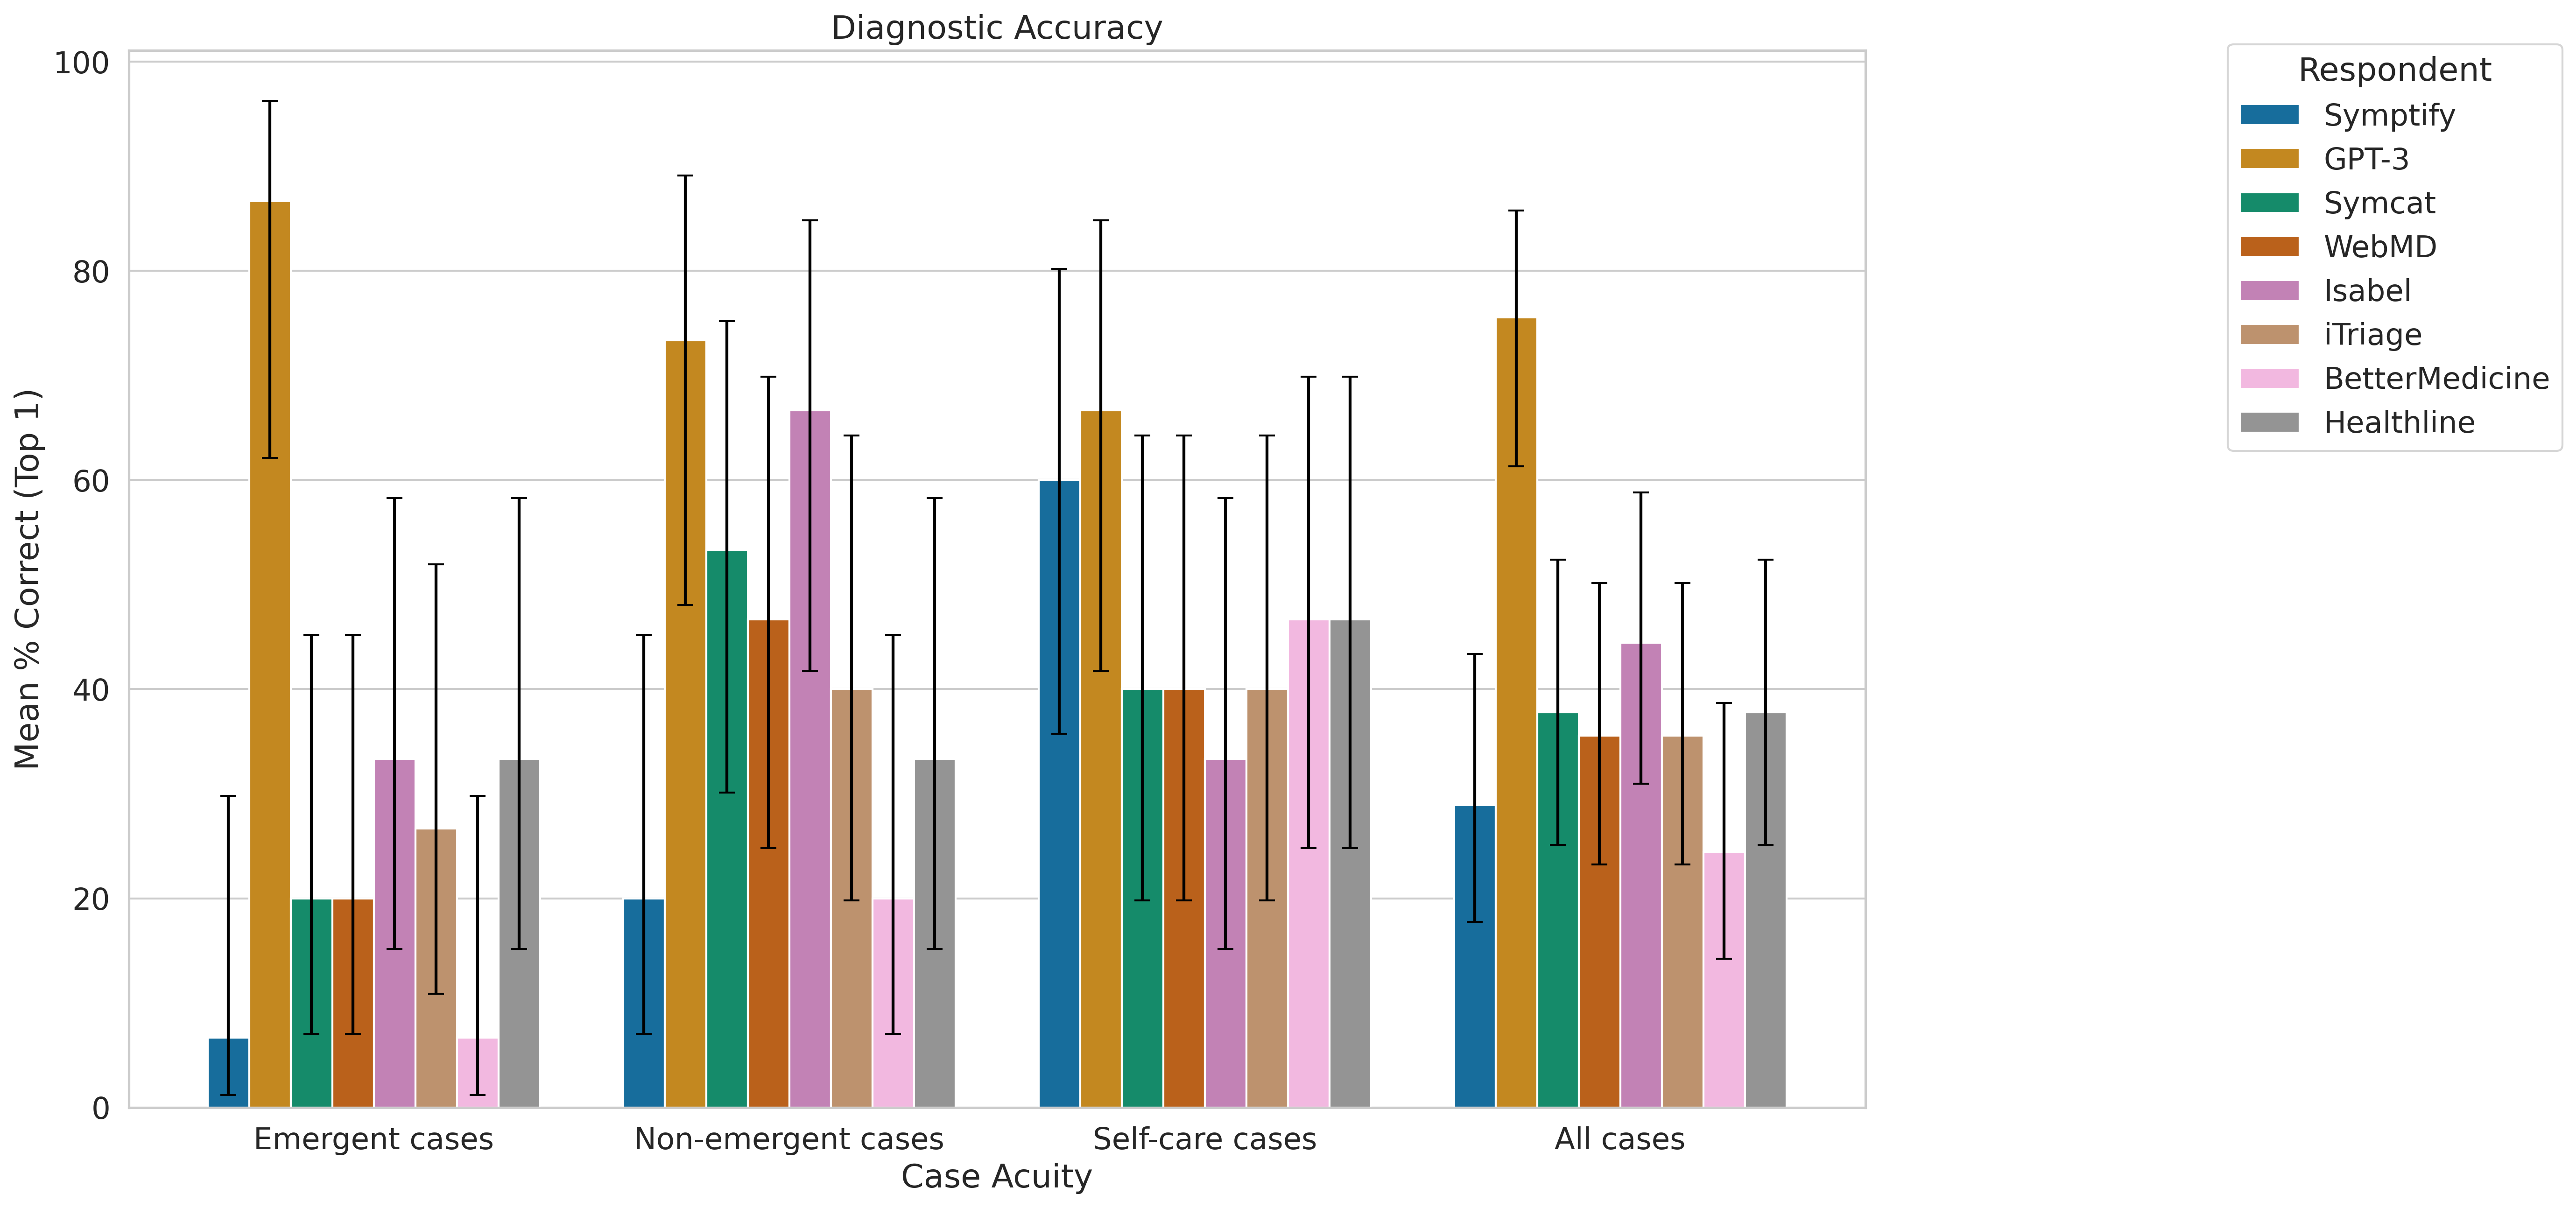

In [9]:
row_order = ["Emergent", "Non-emergent", "Self-care", "All"]
hue_order = ['Symptify', 'GPT-3', 'Symcat', 'WebMD', 'Isabel',
             'iTriage', 'BetterMedicine', 'Healthline']

fig, ax = plt.subplots(figsize=(16, 10))
g = sns.barplot(data=dx_perf, 
            x='Case Acuity', 
            y='Mean',
            hue='Respondent',
            ax=ax,
            order=row_order,
            hue_order=hue_order,
            palette="colorblind"
           )
g.legend(loc='upper right', bbox_to_anchor=(1.41, 1.02), title="Respondent")
g.set_xlabel("Case Acuity")
g.set_ylabel("Mean % Correct (Top 1)")
g.set_xticklabels([a.get_text() + " cases" for a in ax.get_xticklabels()])
g.set_title("Diagnostic Accuracy")

tmp = dx_perf.set_index(["Case Acuity", "Respondent"]).\
    loc[[(case, respondent.get_text()) for respondent in ax.legend_.get_texts() for case in row_order]]
tmp["LB"] = -(tmp["LB"]-tmp["Mean"])
tmp["UB"] = tmp["UB"] - tmp[ "Mean"]
                                                     
ax.errorbar(x=[patch.get_x()+patch.get_width()/2 for patch in ax.patches], 
            y=[patch.get_height() for patch in ax.patches], 
            yerr=tmp[["LB", "UB"]].values.T,
            ls='none', fmt='k', capsize=4);

In [10]:
# Get symptom checker tables
sym_agg = pd.read_html('<div class="table"><div class="table-caption"><div class="highwire-markup-wrapper highwire-get-markup"><div class="highwire-markup"><div xmlns="http://www.w3.org/1999/xhtml" id="content-block" xmlns:xhtml="http://www.w3.org/1999/xhtml"><div class="table-expansion " id="T4"><span class="highwire-journal-article-marker-start"></span><div class="table-caption"><span class="table-label">Table 4</span> <p id="p-39"> Accuracy of diagnosis decision and triage advice for each symptom checker</p><div class="sb-div caption-clear"></div></div><table id="table-4"><thead id="thead-4"><tr id="tr-54"><th colspan="1" rowspan="3" align="left" valign="top" id="th-44" class="table-left table-vtop">Symptom checker (n=23)</th><th colspan="6" rowspan="1" align="center" valign="top" id="th-45" class="table-center table-vtop">Diagnosis</th><th colspan="1" rowspan="3" align="center" valign="top" id="th-46" class="table-center table-vtop"></th><th colspan="8" rowspan="1" align="center" valign="top" id="th-47" class="table-center table-vtop">Triage</th></tr><tr id="tr-55"><th colspan="2" rowspan="1" align="center" valign="top" id="th-48" class="table-center table-vtop">Listed first</th><th colspan="2" rowspan="1" align="center" valign="top" id="th-49" class="table-center table-vtop">Listed in top 3</th><th colspan="2" rowspan="1" align="center" valign="top" id="th-50" class="table-center table-vtop">Listed in top 20</th><th colspan="2" rowspan="1" align="center" valign="top" id="th-51" class="table-center table-vtop">All cases</th><th colspan="2" rowspan="1" align="center" valign="top" id="th-52" class="table-center table-vtop">Emergent care required</th><th colspan="2" rowspan="1" align="center" valign="top" id="th-53" class="table-center table-vtop">Non-emergent care reasonable</th><th colspan="2" rowspan="1" align="center" valign="top" id="th-54" class="table-center table-vtop">Self care reasonable</th></tr><tr id="tr-56"><th colspan="1" rowspan="1" align="center" valign="top" id="th-55" class="table-center table-vtop">Rate*</th><th colspan="1" rowspan="1" align="center" valign="top" id="th-56" class="table-center table-vtop">% (95% CI)</th><th colspan="1" rowspan="1" align="center" valign="top" id="th-57" class="table-center table-vtop">Rate*</th><th colspan="1" rowspan="1" align="center" valign="top" id="th-58" class="table-center table-vtop">% (95% CI)</th><th colspan="1" rowspan="1" align="center" valign="top" id="th-59" class="table-center table-vtop">Rate*</th><th colspan="1" rowspan="1" align="center" valign="top" id="th-60" class="table-center table-vtop">% (95% CI)</th><th colspan="1" rowspan="1" align="center" valign="top" id="th-61" class="table-center table-vtop">Rate*</th><th colspan="1" rowspan="1" align="center" valign="top" id="th-62" class="table-center table-vtop">% (95% CI)</th><th colspan="1" rowspan="1" align="center" valign="top" id="th-63" class="table-center table-vtop">Rate*</th><th colspan="1" rowspan="1" align="center" valign="top" id="th-64" class="table-center table-vtop">% (95% CI)</th><th colspan="1" rowspan="1" align="center" valign="top" id="th-65" class="table-center table-vtop">Rate*</th><th colspan="1" rowspan="1" align="center" valign="top" id="th-66" class="table-center table-vtop">% (95% CI)</th><th colspan="1" rowspan="1" align="center" valign="top" id="th-67" class="table-center table-vtop">Rate*</th><th colspan="1" rowspan="1" align="center" valign="top" id="th-68" class="table-center table-vtop">% (95% CI)</th></tr></thead><tbody id="tbody-4"><tr id="tr-57"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-405" class="table-left table-vmiddle">Ask MD</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-406" class="table-center table-vmiddle">17/40</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-407" class="table-center table-vmiddle">43 (26 to 59)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-408" class="table-center table-vmiddle">27/40</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-409" class="table-center table-vmiddle">68 (52 to 83)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-410" class="table-center table-vmiddle">30/40</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-411" class="table-center table-vmiddle">75 (61 to 89)</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-412" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-413" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-414" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-415" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-416" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-417" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-418" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-419" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-420" class="table-center table-vmiddle">—†</td></tr><tr id="tr-58"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-421" class="table-left table-vmiddle">BetterMedicine</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-422" class="table-center table-vmiddle">11/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-423" class="table-center table-vmiddle">24 (11 to 38)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-424" class="table-center table-vmiddle">13/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-425" class="table-center table-vmiddle">29 (15 to 43)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-426" class="table-center table-vmiddle">17/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-427" class="table-center table-vmiddle">38 (23 to 53)</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-428" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-429" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-430" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-431" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-432" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-433" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-434" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-435" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-436" class="table-center table-vmiddle">—†</td></tr><tr id="tr-59"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-437" class="table-left table-vmiddle">DocResponse</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-438" class="table-center table-vmiddle">18/36</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-439" class="table-center table-vmiddle">50 (33 to 67)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-440" class="table-center table-vmiddle">24/36</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-441" class="table-center table-vmiddle">67 (50 to 83)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-442" class="table-center table-vmiddle">26/36</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-443" class="table-center table-vmiddle">72 (57 to 88)</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-444" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-445" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-446" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-447" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-448" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-449" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-450" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-451" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-452" class="table-center table-vmiddle">—†</td></tr><tr id="tr-60"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-453" class="table-left table-vmiddle">Doctor Diagnose</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-454" class="table-center table-vmiddle">16/39</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-455" class="table-center table-vmiddle">41 (25 to 57)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-456" class="table-center table-vmiddle">17/39</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-457" class="table-center table-vmiddle">44 (27 to 60)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-458" class="table-center table-vmiddle">18/39</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-459" class="table-center table-vmiddle">46 (30 to 63)</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-460" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-461" class="table-center table-vmiddle">10/16</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-462" class="table-center table-vmiddle">63 (36 to 89)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-463" class="table-center table-vmiddle">8/10</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-464" class="table-center table-vmiddle">80 (13 to 100)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-465" class="table-center table-vmiddle">2/3</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-466" class="table-center table-vmiddle">67 (0 to 100)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-467" class="table-center table-vmiddle">0/3</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-468" class="table-center table-vmiddle">0 (0 to0)</td></tr><tr id="tr-61"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-469" class="table-left table-vmiddle">Drugs.com</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-470" class="table-center table-vmiddle">17/43</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-471" class="table-center table-vmiddle">40 (24 to 55)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-472" class="table-center table-vmiddle">20/43</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-473" class="table-center table-vmiddle">47 (31 to 63)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-474" class="table-center table-vmiddle">25/43</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-475" class="table-center table-vmiddle">58 (43 to74)</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-476" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-477" class="table-center table-vmiddle">25/42</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-478" class="table-center table-vmiddle">60 (44 to75)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-479" class="table-center table-vmiddle">8/14</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-480" class="table-center table-vmiddle">57 (27 to 87)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-481" class="table-center table-vmiddle">9/15</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-482" class="table-center table-vmiddle">60 (32 to 88)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-483" class="table-center table-vmiddle">8/13</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-484" class="table-center table-vmiddle">62 (31 to 92)</td></tr><tr id="tr-62"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-485" class="table-left table-vmiddle">EarlyDoc</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-486" class="table-center table-vmiddle">6/19</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-487" class="table-center table-vmiddle">32 (9 to 55)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-488" class="table-center table-vmiddle">7/19</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-489" class="table-center table-vmiddle">33 (9 to 57)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-490" class="table-center table-vmiddle">7/19</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-491" class="table-center table-vmiddle">33 (9 to57)</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-492" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-493" class="table-center table-vmiddle">9/17</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-494" class="table-center table-vmiddle">53 (26 to79)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-495" class="table-center table-vmiddle">4/6</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-496" class="table-center table-vmiddle">67 (12 to 100)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-497" class="table-center table-vmiddle">3/5</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-498" class="table-center table-vmiddle">60 (0 to 100)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-499" class="table-center table-vmiddle">2/6</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-500" class="table-center table-vmiddle">33 (0 to 88)</td></tr><tr id="tr-63"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-501" class="table-left table-vmiddle">Esagil</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-502" class="table-center table-vmiddle">9/44</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-503" class="table-center table-vmiddle">20 (8 to33)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-504" class="table-center table-vmiddle">15/44</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-505" class="table-center table-vmiddle">34 (24 to 54)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-506" class="table-center table-vmiddle">22/44</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-507" class="table-center table-vmiddle">50 (35 to65)</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-508" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-509" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-510" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-511" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-512" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-513" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-514" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-515" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-516" class="table-center table-vmiddle">—†</td></tr><tr id="tr-64"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-517" class="table-left table-vmiddle">Family Doctor</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-518" class="table-center table-vmiddle">20/43</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-519" class="table-center table-vmiddle">47 (31 to62)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-520" class="table-center table-vmiddle">24/43</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-521" class="table-center table-vmiddle">56 (40 to 71)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-522" class="table-center table-vmiddle">24/43</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-523" class="table-center table-vmiddle">56 (40 to71)</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-524" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-525" class="table-center table-vmiddle">22/41</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-526" class="table-center table-vmiddle">54 (38 to70)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-527" class="table-center table-vmiddle">6/12</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-528" class="table-center table-vmiddle">50 (17 to 83)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-529" class="table-center table-vmiddle">7/14</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-530" class="table-center table-vmiddle">50 (20 to 80)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-531" class="table-center table-vmiddle">9/15</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-532" class="table-center table-vmiddle">60 (32 to 88)</td></tr><tr id="tr-65"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-533" class="table-left table-vmiddle">FreeMD</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-534" class="table-center table-vmiddle">16/44</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-535" class="table-center table-vmiddle">36 (22 to51)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-536" class="table-center table-vmiddle">20/44</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-537" class="table-center table-vmiddle">45 (30 to 61)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-538" class="table-center table-vmiddle">21/44</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-539" class="table-center table-vmiddle">48 (32 to63)</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-540" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-541" class="table-center table-vmiddle">26/44</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-542" class="table-center table-vmiddle">59 (44 to74)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-543" class="table-center table-vmiddle">10/15</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-544" class="table-center table-vmiddle">67 (40 to 94)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-545" class="table-center table-vmiddle">13/15</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-546" class="table-center table-vmiddle">87 (67 to 100)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-547" class="table-center table-vmiddle">3/14</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-548" class="table-center table-vmiddle">21 (0 to 46)</td></tr><tr id="tr-66"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-549" class="table-left table-vmiddle">HMS Family Health Guide</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-550" class="table-center table-vmiddle">13/38</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-551" class="table-center table-vmiddle">34 (18 to50)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-552" class="table-center table-vmiddle">20/38</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-553" class="table-center table-vmiddle">52 (39 to 72)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-554" class="table-center table-vmiddle">21/38</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-555" class="table-center table-vmiddle">55 (39 to72)</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-556" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-557" class="table-center table-vmiddle">32/40</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-558" class="table-center table-vmiddle">78 (64 to91)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-559" class="table-center table-vmiddle">13/14</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-560" class="table-center table-vmiddle">93 (77 to 100)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-561" class="table-center table-vmiddle">11/13</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-562" class="table-center table-vmiddle">85 (62 to 100)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-563" class="table-center table-vmiddle">8/13</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-564" class="table-center table-vmiddle">62 (31 to 92)</td></tr><tr id="tr-67"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-565" class="table-left table-vmiddle">Healthline</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-566" class="table-center table-vmiddle">17/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-567" class="table-center table-vmiddle">38 (23 to53)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-568" class="table-center table-vmiddle">24/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-569" class="table-center table-vmiddle">53 (37 to 68)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-570" class="table-center table-vmiddle">26/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-571" class="table-center table-vmiddle">58 (43 to73)</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-572" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-573" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-574" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-575" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-576" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-577" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-578" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-579" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-580" class="table-center table-vmiddle">—†</td></tr><tr id="tr-68"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-581" class="table-left table-vmiddle">Healthwise</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-582" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-583" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-584" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-585" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-586" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-587" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-588" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-589" class="table-center table-vmiddle">19/44</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-590" class="table-center table-vmiddle">43 (28 to58)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-591" class="table-center table-vmiddle">15/15</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-592" class="table-center table-vmiddle">100 (100 to 100)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-593" class="table-center table-vmiddle">1/15</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-594" class="table-center table-vmiddle">7 (0 to 21)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-595" class="table-center table-vmiddle">3/14</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-596" class="table-center table-vmiddle">21 (0 to 46)</td></tr><tr id="tr-69"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-597" class="table-left table-vmiddle">Healthy Children</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-598" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-599" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-600" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-601" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-602" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-603" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-604" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-605" class="table-center table-vmiddle">11/15</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-606" class="table-center table-vmiddle">73 (48 to99)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-607" class="table-center table-vmiddle">3/3</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-608" class="table-center table-vmiddle">100 (100 to 100)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-609" class="table-center table-vmiddle">5/5</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-610" class="table-center table-vmiddle">100 (100 to 100)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-611" class="table-center table-vmiddle">3/7</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-612" class="table-center table-vmiddle">43 (0 to 92)</td></tr><tr id="tr-70"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-613" class="table-left table-vmiddle">Isabel</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-614" class="table-center table-vmiddle">20/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-615" class="table-center table-vmiddle">44 (29 to60)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-616" class="table-center table-vmiddle">31/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-617" class="table-center table-vmiddle">69 (55 to 83)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-618" class="table-center table-vmiddle">38/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-619" class="table-center table-vmiddle">84 (73 to 95)</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-620" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-621" class="table-center table-vmiddle">23/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-622" class="table-center table-vmiddle">51 (36 to66)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-623" class="table-center table-vmiddle">15/15</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-624" class="table-center table-vmiddle">100 (100 to 100)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-625" class="table-center table-vmiddle">8/15</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-626" class="table-center table-vmiddle">53 (25 to 82)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-627" class="table-center table-vmiddle">0/15</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-628" class="table-center table-vmiddle">0 (0 to 0)</td></tr><tr id="tr-71"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-629" class="table-left table-vmiddle">iTriage</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-630" class="table-center table-vmiddle">16/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-631" class="table-center table-vmiddle">36 (22 to51)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-632" class="table-center table-vmiddle">29/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-633" class="table-center table-vmiddle">64 (49 to 78)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-634" class="table-center table-vmiddle">34/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-635" class="table-center table-vmiddle">77 (64 to90)</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-636" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-637" class="table-center table-vmiddle">14/43</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-638" class="table-center table-vmiddle">33 (19 to48)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-639" class="table-center table-vmiddle">14/14</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-640" class="table-center table-vmiddle">100 (100 to 100)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-641" class="table-center table-vmiddle">0/14</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-642" class="table-center table-vmiddle">0 (0 to 0)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-643" class="table-center table-vmiddle">0/15</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-644" class="table-center table-vmiddle">0 (0 to 0)</td></tr><tr id="tr-72"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-645" class="table-left table-vmiddle">Mayo Clinic</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-646" class="table-center table-vmiddle">7/41</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-647" class="table-center table-vmiddle">17 (5 to29)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-648" class="table-center table-vmiddle">24/41</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-649" class="table-center table-vmiddle">59 (43 to 74)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-650" class="table-center table-vmiddle">31/41</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-651" class="table-center table-vmiddle">76 (62 to89)</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-652" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-653" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-654" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-655" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-656" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-657" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-658" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-659" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-660" class="table-center table-vmiddle">—†</td></tr><tr id="tr-73"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-661" class="table-left table-vmiddle">MEDoctor</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-662" class="table-center table-vmiddle">2/37</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-663" class="table-center table-vmiddle">5 (0 to13)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-664" class="table-center table-vmiddle">16/37</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-665" class="table-center table-vmiddle">43 (26 to 60)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-666" class="table-center table-vmiddle">16/37</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-667" class="table-center table-vmiddle">43 (26 to60)</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-668" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-669" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-670" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-671" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-672" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-673" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-674" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-675" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-676" class="table-center table-vmiddle">—†</td></tr><tr id="tr-74"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-677" class="table-left table-vmiddle">NHS</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-678" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-679" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-680" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-681" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-682" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-683" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-684" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-685" class="table-center table-vmiddle">23/44</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-686" class="table-center table-vmiddle">52 (37 to68)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-687" class="table-center table-vmiddle">13/15</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-688" class="table-center table-vmiddle">87 (67 to 100)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-689" class="table-center table-vmiddle">3/15</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-690" class="table-center table-vmiddle">20 (0 to 43)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-691" class="table-center table-vmiddle">7/14</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-692" class="table-center table-vmiddle">50 (20 to 80)</td></tr><tr id="tr-75"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-693" class="table-left table-vmiddle">Steps2Care </td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-694" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-695" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-696" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-697" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-698" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-699" class="table-center table-vmiddle">—‡</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-700" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-701" class="table-center table-vmiddle">30/42</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-702" class="table-center table-vmiddle">71 (57 to86)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-703" class="table-center table-vmiddle">12/14</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-704" class="table-center table-vmiddle">86 (65 to 100)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-705" class="table-center table-vmiddle">10/14</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-706" class="table-center table-vmiddle">71 (44 to 98)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-707" class="table-center table-vmiddle">8/14</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-708" class="table-center table-vmiddle">57 (27 to 87)</td></tr><tr id="tr-76"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-709" class="table-left table-vmiddle">Symcat</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-710" class="table-center table-vmiddle">18/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-711" class="table-center table-vmiddle">40 (25 to55)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-712" class="table-center table-vmiddle">32/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-713" class="table-center table-vmiddle">71 (57 to 85)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-714" class="table-center table-vmiddle">34/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-715" class="table-center table-vmiddle">76 (62 to89)</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-716" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-717" class="table-center table-vmiddle">20/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-718" class="table-center table-vmiddle">44 (29 to60)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-719" class="table-center table-vmiddle">8/15</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-720" class="table-center table-vmiddle">53 (25 to 82)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-721" class="table-center table-vmiddle">12/15</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-722" class="table-center table-vmiddle">80 (57 to 100)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-723" class="table-center table-vmiddle">0/15</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-724" class="table-center table-vmiddle">0 (0 to 0)</td></tr><tr id="tr-77"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-725" class="table-left table-vmiddle">Symptify</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-726" class="table-center table-vmiddle">13/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-727" class="table-center table-vmiddle">29 (15 to43)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-728" class="table-center table-vmiddle">16/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-729" class="table-center table-vmiddle">36 (22 to 51)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-730" class="table-center table-vmiddle">20/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-731" class="table-center table-vmiddle">44 (29 to60)</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-732" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-733" class="table-center table-vmiddle">28/40</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-734" class="table-center table-vmiddle">70 (55 to85)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-735" class="table-center table-vmiddle">11/12</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-736" class="table-center table-vmiddle">92 (73 to 100)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-737" class="table-center table-vmiddle">10/14</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-738" class="table-center table-vmiddle">71 (44 to 98)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-739" class="table-center table-vmiddle">7/14</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-740" class="table-center table-vmiddle">50 (20 to 80)</td></tr><tr id="tr-78"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-741" class="table-left table-vmiddle">Symptomate</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-742" class="table-center table-vmiddle">10/32</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-743" class="table-center table-vmiddle">31 (14 to48)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-744" class="table-center table-vmiddle">11/32</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-745" class="table-center table-vmiddle">34 (17 to 52)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-746" class="table-center table-vmiddle">11/32</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-747" class="table-center table-vmiddle">34 (17 to52)</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-748" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-749" class="table-center table-vmiddle">9/14</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-750" class="table-center table-vmiddle">64 (36 to93)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-751" class="table-center table-vmiddle">7/9</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-752" class="table-center table-vmiddle">76 (44 to 100)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-753" class="table-center table-vmiddle">2/3</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-754" class="table-center table-vmiddle">67 (0 to 100)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-755" class="table-center table-vmiddle">0/2</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-756" class="table-center table-vmiddle">0 (0 to 0)</td></tr><tr id="tr-79"><td colspan="1" rowspan="1" align="left" valign="middle" id="td-757" class="table-left table-vmiddle">WebMD</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-758" class="table-center table-vmiddle">16/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-759" class="table-center table-vmiddle">36 (21 to50)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-760" class="table-center table-vmiddle">23/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-761" class="table-center table-vmiddle">51 (36 to 66)</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-762" class="table-center table-vmiddle">28/45</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-763" class="table-center table-vmiddle">62 (47 to77)</td><td colspan="1" rowspan="1" align="center" valign="top" id="td-764" class="table-center table-vtop"></td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-765" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-766" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-767" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-768" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-769" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-770" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-771" class="table-center table-vmiddle">—†</td><td colspan="1" rowspan="1" align="center" valign="middle" id="td-772" class="table-center table-vmiddle">—†</td></tr></tbody></table><div class="table-foot"><p id="p-40">HMS=Harvard Medical School; NHS=National Health Service.</p><p id="p-41">*Number of correct SP evaluations divided by applicable SP evaluations. Some SP vignettes could not be applied to a given symptom checker. For example, we could not evaluate an SP vignette aimed at adults if the symptom checker was for children.</p><p id="p-42">†Symptom checker does not provide triage advice.</p><p id="p-43">‡Symptom checker does not provide diagnosis suggestions.</p><ul class="table-footnotes"></ul></div><span class="highwire-journal-article-marker-end"></span></div><span id="related-urls"></span></div></div></div></div><div class="table-inline"><div class="callout"><span>View this table:</span><ul class="callout-links"><li><a href="/highwire/markup/900627/expansion?width=1000&amp;height=500&amp;iframe=true&amp;postprocessors=highwire_figures%2Chighwire_math" class="colorbox colorbox-load table-expand-popup init-colorbox-processed cboxElement" rel="gallery-fragment-tables">View popup</a></li><li><a href="##" class="table-expand-inline highwireTablesMarkupProcessor-processed" data-table-url="/highwire/markup/900627/expansion?postprocessors=highwire_figures%2Chighwire_math">Collapse inline</a></li></ul></div></div></div>')[0]
del sym_agg['Unnamed: 7_level_0']

# Remove CI estimates
sym_agg.drop("% (95% CI)", level=2, axis=1, inplace=True)

# Split into separate tables for dx and triage
sym_agg_triage = sym_agg.loc[:, ["Symptom checker (n=23)", "Triage"]]

# Rename columns
sym_agg_triage.columns = sym_agg_triage.columns.get_level_values(1)

# Long format
sym_agg_triage = sym_agg_triage.melt("Symptom checker (n=23)", var_name="Correct Triage", value_name="Rate")
sym_agg_triage["Correct Triage"].replace({
    "Emergent care required": "Emergent",
    "Non-emergent care reasonable": "Non-emergent",
    "Self care reasonable": "Self-care"
}, inplace=True)

# Remove symptom checkers that do not predict Dx
sym_agg_triage = sym_agg_triage.loc[~sym_agg_triage["Rate"].str.contains("—")]

# Get to format that we already have code for
sym_agg_triage["N"] = sym_agg_triage["Rate"].map(lambda s: s.split("/")[1])
sym_agg_triage["# Correct"] = sym_agg_triage["Rate"].map(lambda s: s.split("/")[0])
del sym_agg_triage["Rate"]
sym_agg_triage.rename({"Symptom checker (n=23)": "Symptom Checker"}, inplace=True, axis=1)
sym_agg_triage.set_index(["Symptom Checker", "Correct Triage"], inplace=True)
sym_agg_triage.head()

,,N,# Correct
Symptom Checker,Correct Triage,,
Doctor Diagnose,All cases,16,10
Drugs.com,All cases,42,25
EarlyDoc,All cases,17,9
Family Doctor,All cases,41,22
FreeMD,All cases,44,26


In [11]:
# Keep only those that predicted everything
sym_names = list(sym_agg_triage[sym_agg_triage["N"] == "45"].index.get_level_values(0))
sym_agg_triage = sym_agg_triage.loc[sym_names]
sym_agg_triage

N # Correct
Symptom Checker Correct Triage              
Isabel          All cases       45        23
                Emergent        15        15
                Non-emergent    15         8
                Self-care       15         0
Symcat          All cases       45        20
                Emergent        15         8
                Non-emergent    15        12
                Self-care       15         0